In [1]:
library(keras) # for deep learning
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas

In [2]:
setwd('./')
#ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_resampled.csv")
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

In [3]:
ts_df <- ts_df[,2]
x = ts(ts_df, start=0 , frequency=1)
ts_df = ts_df/300000 # paso la unidad a slots
ts_df = ts(ts_df, start=0, frequency=1)

In [4]:
length(ts_df)

[1] 6048

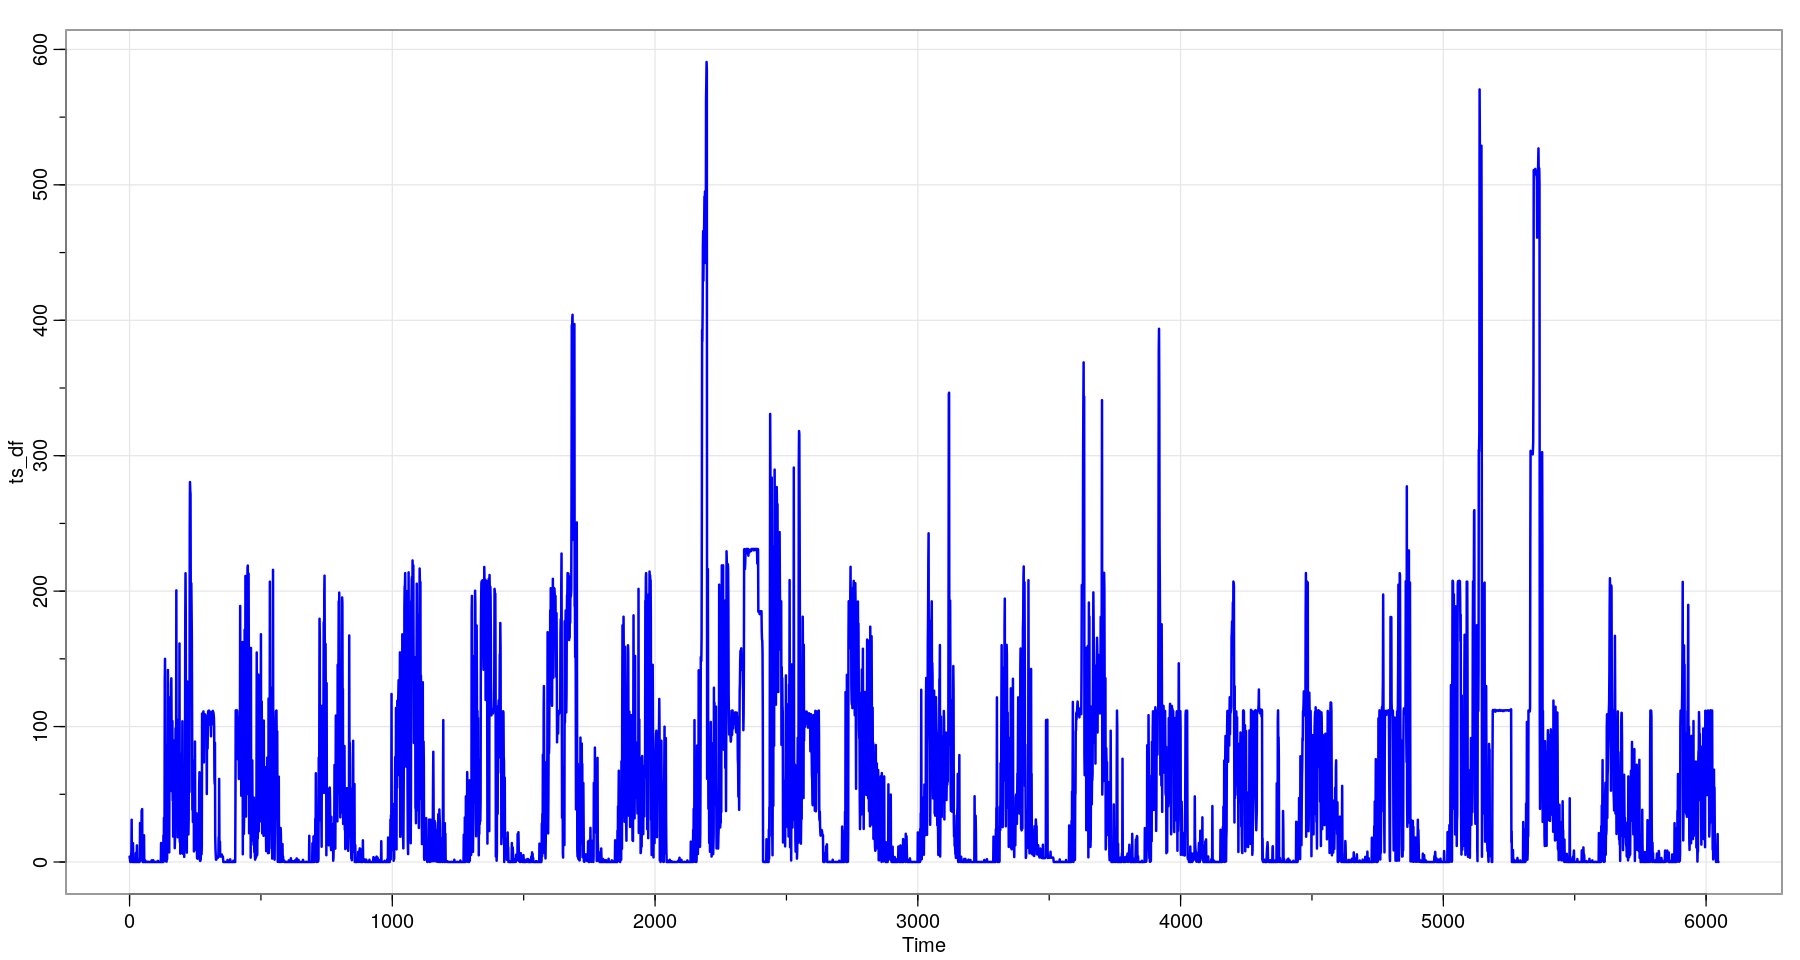

In [5]:
tsplot(ts_df, lwd=2, col=4)

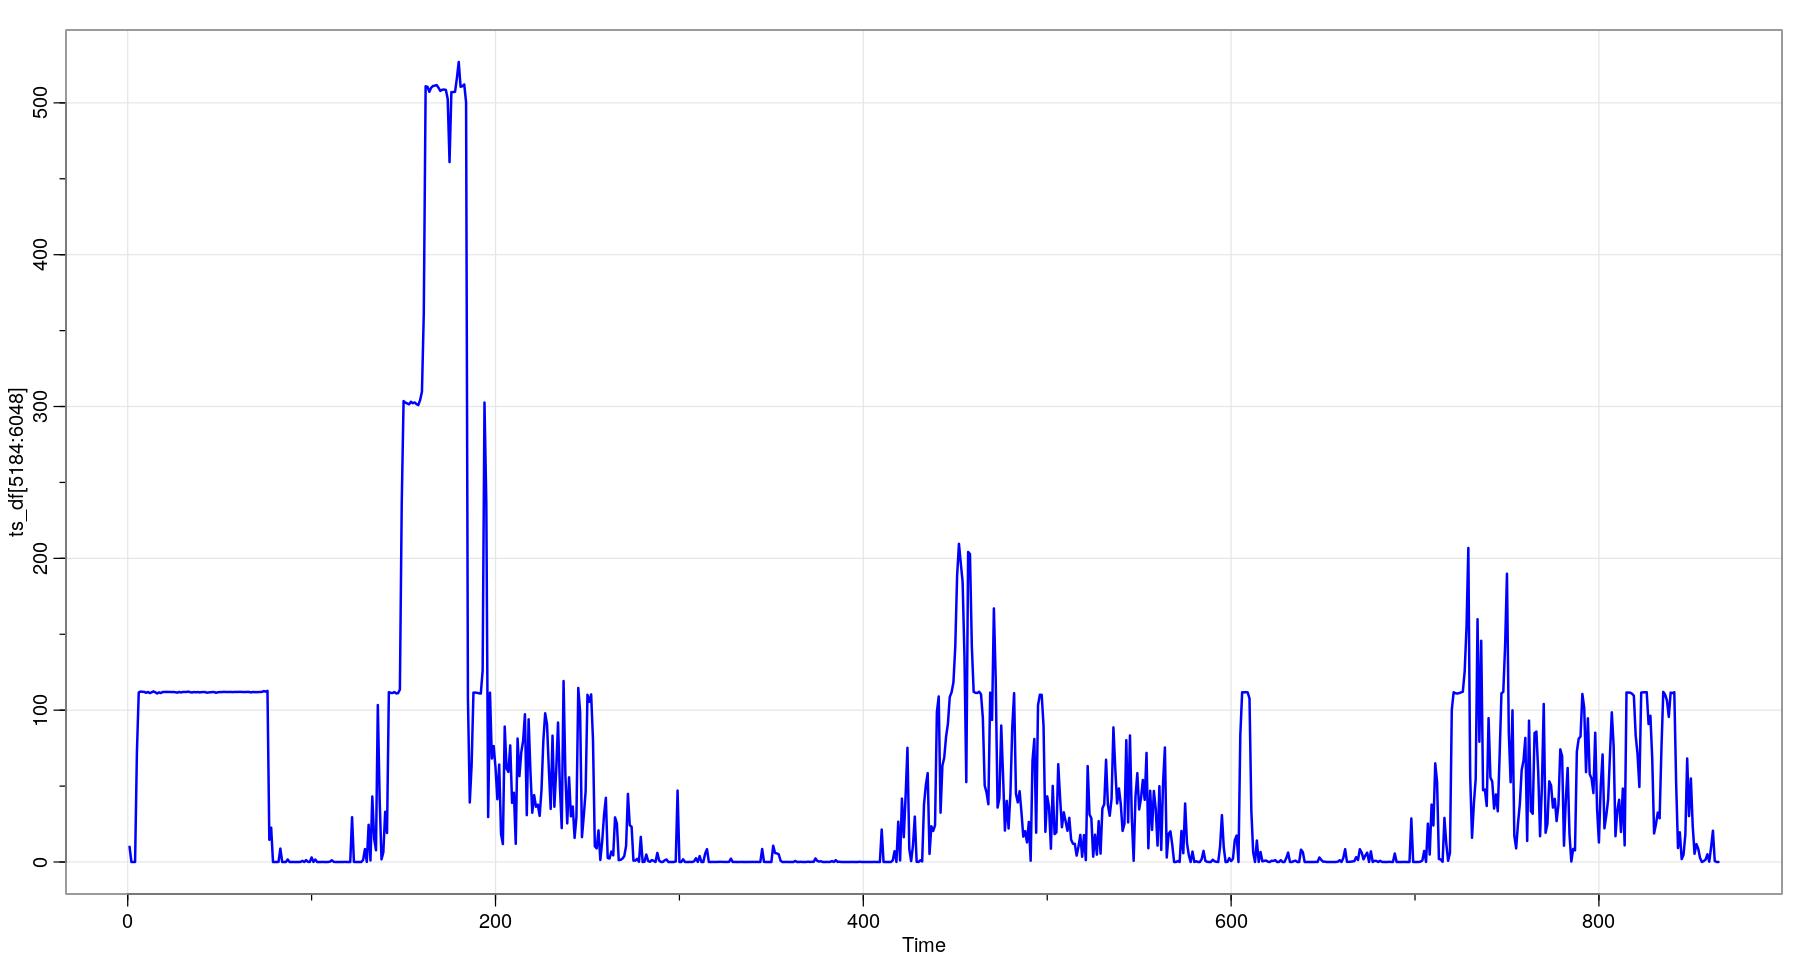

In [6]:
tsplot(ts_df[5184:6048], lwd=2, col=4)


Call:
lm(formula = ldn ~ time(ldn))

Residuals:
   Min     1Q Median     3Q    Max 
-55.27 -53.09 -34.12  38.99 537.10 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.267e+01  1.977e+00  26.639   <2e-16 ***
time(ldn)   4.297e-04  5.663e-04   0.759    0.448    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 76.89 on 6046 degrees of freedom
Multiple R-squared:  9.52e-05,	Adjusted R-squared:  -7.019e-05 
F-statistic: 0.5756 on 1 and 6046 DF,  p-value: 0.4481


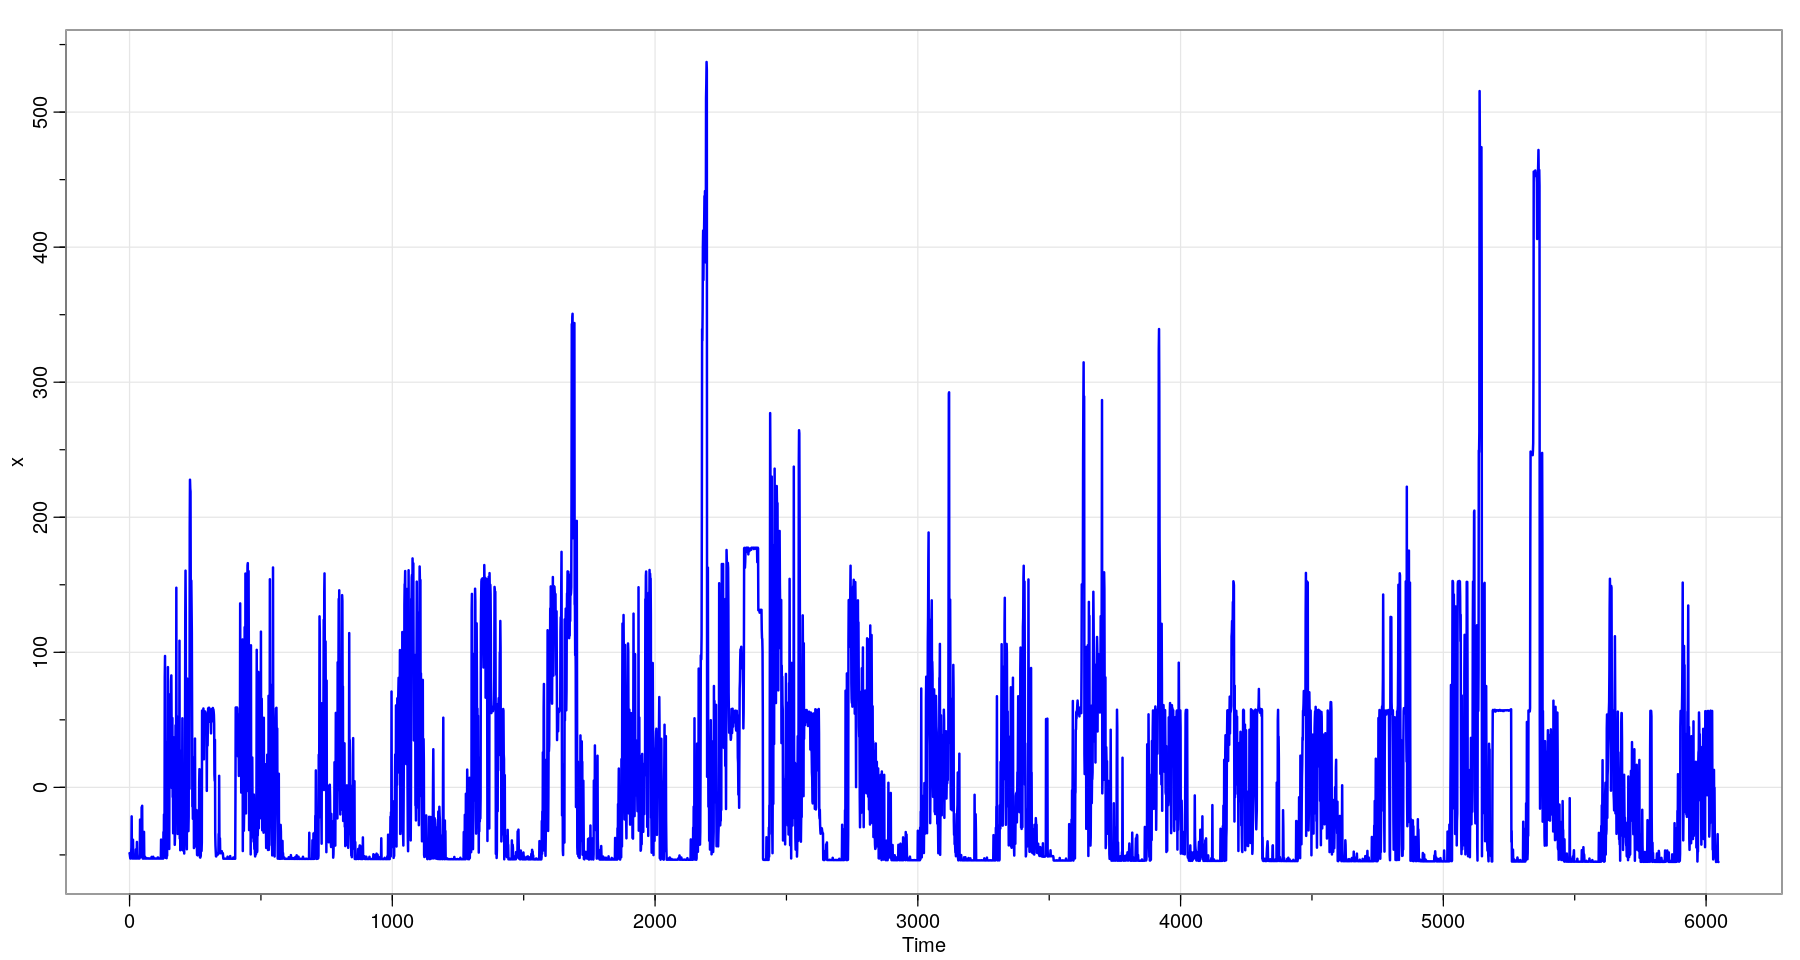

In [7]:
#fit = lm(cmort~time(cmort))
#summary(fit)

#ldn = log(ts_df+1)

ldn = ts_df

fit = lm(ldn~time(ldn))
summary(fit)
x=residuals(fit)
x=ts(x, start=0, freq=1)
tsplot(x, lwd=2, col=4)

In [8]:
window=3
pred = 1
x_train = x[time(x)<5500]
n=length(x_train)
print(n)

X_train = matrix(,n-window-pred+1,window)
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,] = x_train[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

head(X_train)
head(y_train)
head(x_train)

[1] 5500


[1] 5497    3

[1] 5497    1

-48.72740,-49.65860,-51.35365
-49.65860,-51.35365,-52.67211
-51.35365,-52.67211,-52.66195
-52.67211,-52.66195,-52.65192
-52.66195,-52.65192,-48.73295
-52.65192,-48.73295,-44.67359


-52.67211
-52.66195
-52.65192
-48.73295
-44.67359
-21.49013


1         2         3         4         5         6 
-48.72740 -49.65860 -51.35365 -52.67211 -52.66195 -52.65192

In [9]:
# Armo el "tensor" de entrenamiento
X_train = array(X_train, dim = c(n-window-pred+1, window, 1))

#dimensiones: no. muestras, tiempos involucrados, no. features
dim(X_train)

[1] 5497    3    1

## Modelo 1: una única capa densa.

Esto coincide con el modelo lineal del autorregresivo que ya vimos.

In [10]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [11]:
summary(model1)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten (Flatten)                   (None, 3)                       0           
________________________________________________________________________________
dense (Dense)                       (None, 1)                       4           
Total params: 4
Trainable params: 4
Non-trainable params: 0
________________________________________________________________________________


In [12]:
model1 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [13]:
trained_model <- model1 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 300, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



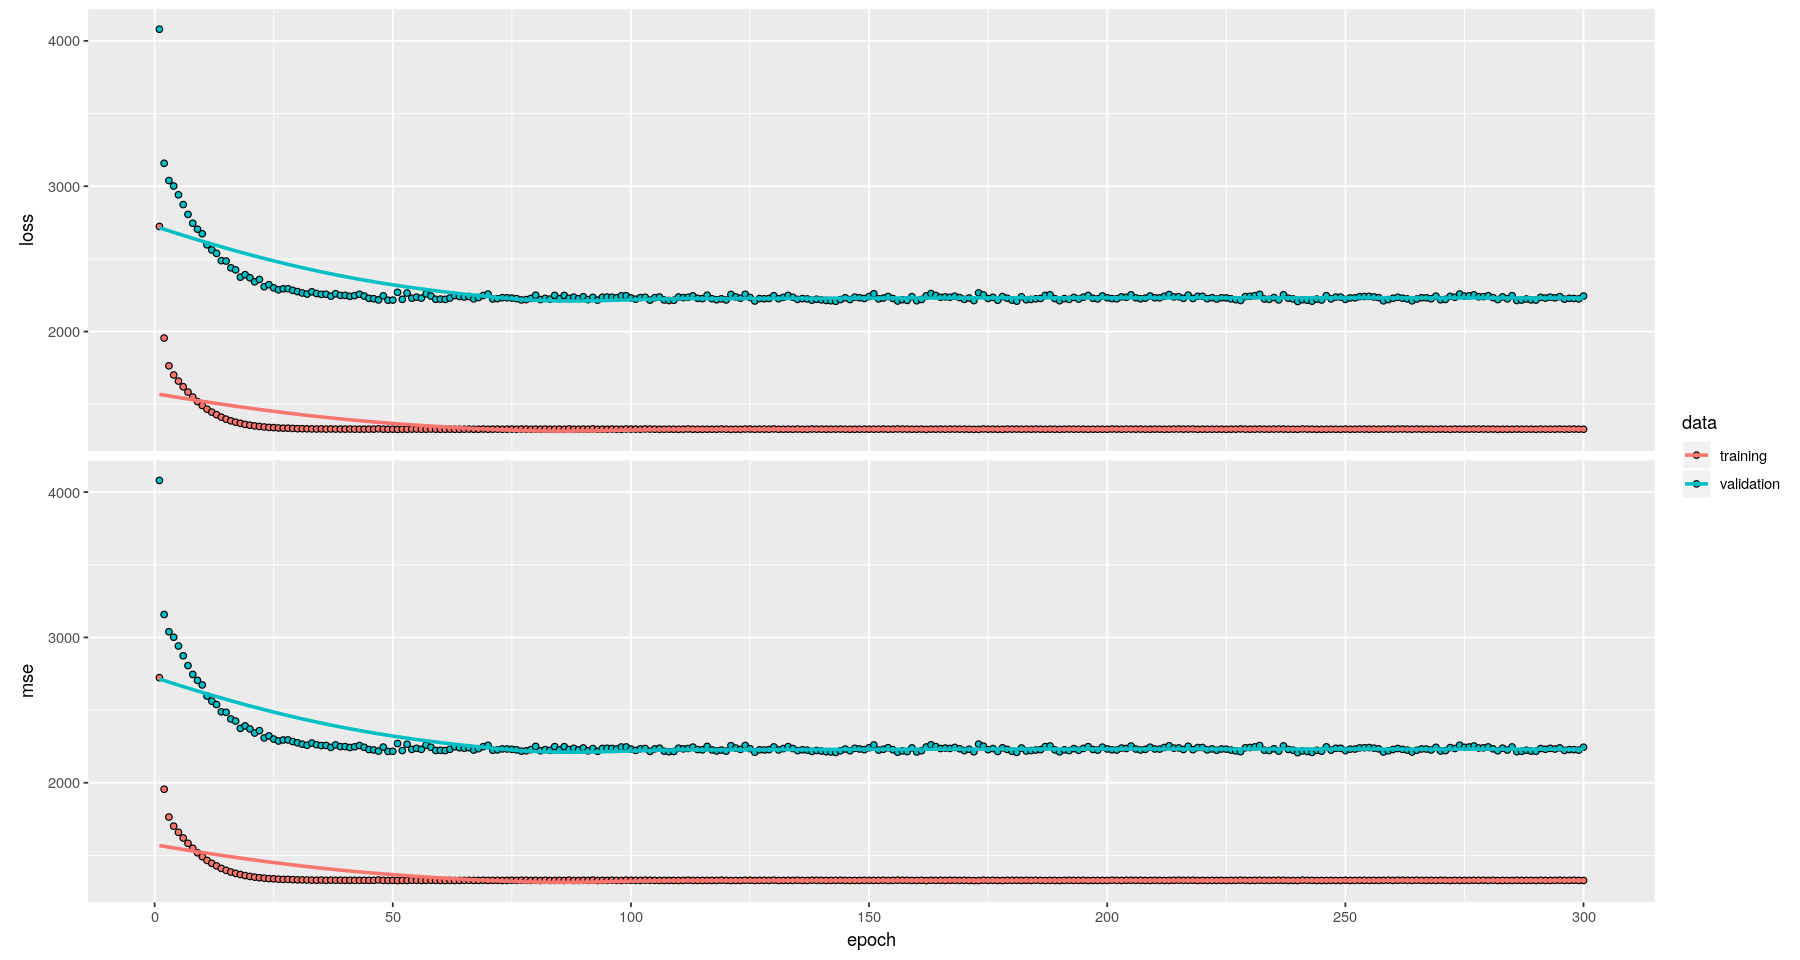

In [14]:
plot(trained_model)

In [15]:
evaluate(model1,X_train,y_train)

loss      mse 
1418.559 1418.559

In [16]:
model1$weights

[[1]]
<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.14524432],
       [0.0634198 ],
       [0.67755824]], dtype=float32)>

[[2]]
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-0.12281615], dtype=float32)>


In [17]:
arima(x_train,order = c(3,0,0), method="CSS")


Call:
arima(x = x_train, order = c(3, 0, 0), method = "CSS")

Coefficients:
         ar1     ar2     ar3  intercept
      0.7212  0.0351  0.1527     2.1982
s.e.  0.0133  0.0165  0.0133     5.5686

sigma^2 estimated as 1414:  part log likelihood = -27752.61

In [18]:
# nuevos datos para prediccion 
start_test=5184
new_t = seq(start_test,6048-1,by=1)
new_t = ts(new_t,start=start_test,freq=1)
new_data = data.frame(t=new_t)

ndata <- data.frame(t = new_data)

ts_fitted_trend = ts(predict(fit, new_data=ndata), start=5184, freq=1)


In [19]:
new_t

A Time Series:
  [1] 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198
 [16] 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213
 [31] 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228
 [46] 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243
 [61] 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258
 [76] 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273
 [91] 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288
[106] 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303
[121] 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318
[136] 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333
[151] 5334 5335 5336 5337 5338 5339 5340 5341 5342 5343 5344 5345 5346 5347 5348
[166] 5349 5350 5351 5352 5353 5354 5355 5356 5357 5358 5359 5360 5361 5362 5363
[181] 5364 5365 5366 5367 5368 5369 5370 5371 5372 5373 5374 5375 5376 5377 5378
[196] 5379 5380 5381 5382 5383 5384 5385 5386 5387 5388 5389 5390 5391 5392 5393
[211] 5394 5395 5396 5397 5398 5399 5400 5401 5402 5403 5404 5405 5406 5407 5408
[226] 5409 5410 5411 5412 5413 5414 5415 5416 5417 5418 5419 5420 5421 5422 5423
[241] 5424 5425 5426 5427 5428 5429 5430 5431 5432 5433 5434 5435 5436 5437 5438
[256] 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5449 5450 5451 5452 5453
[271] 5454 5455 5456 5457 5458 5459 5460 5461 5462 5463 5464 5465 5466 5467 5468
[286] 5469 5470 5471 5472 5473 5474 5475 5476 5477 5478 5479 5480 5481 5482 5483
[301] 5484 5485 5486 5487 5488 5489 5490 5491 5492 5493 5494 5495 5496 5497 5498
[316] 5499 5500 5501 5502 5503 5504 5505 5506 5507 5508 5509 5510 5511 5512 5513
[331] 5514 5515 5516 5517 5518 5519 5520 5521 5522 5523 5524 5525 5526 5527 5528
[346] 5529 5530 5531 5532 5533 5534 5535 5536 5537 5538 5539 5540 5541 5542 5543
[361] 5544 5545 5546 5547 5548 5549 5550 5551 5552 5553 5554 5555 5556 5557 5558
[376] 5559 5560 5561 5562 5563 5564 5565 5566 5567 5568 5569 5570 5571 5572 5573
[391] 5574 5575 5576 5577 5578 5579 5580 5581 5582 5583 5584 5585 5586 5587 5588
[406] 5589 5590 5591 5592 5593 5594 5595 5596 5597 5598 5599 5600 5601 5602 5603
[421] 5604 5605 5606 5607 5608 5609 5610 5611 5612 5613 5614 5615 5616 5617 5618
[436] 5619 5620 5621 5622 5623 5624 5625 5626 5627 5628 5629 5630 5631 5632 5633
[451] 5634 5635 5636 5637 5638 5639 5640 5641 5642 5643 5644 5645 5646 5647 5648
[466] 5649 5650 5651 5652 5653 5654 5655 5656 5657 5658 5659 5660 5661 5662 5663
[481] 5664 5665 5666 5667 5668 5669 5670 5671 5672 5673 5674 5675 5676 5677 5678
[496] 5679 5680 5681 5682 5683 5684 5685 5686 5687 5688 5689 5690 5691 5692 5693
[511] 5694 5695 5696 5697 5698 5699 5700 5701 5702 5703 5704 5705 5706 5707 5708
[526] 5709 5710 5711 5712 5713 5714 5715 5716 5717 5718 5719 5720 5721 5722 5723
[541] 5724 5725 5726 5727 5728 5729 5730 5731 5732 5733 5734 5735 5736 5737 5738
[556] 5739 5740 5741 5742 5743 5744 5745 5746 5747 5748 5749 5750 5751 5752 5753
[571] 5754 5755 5756 5757 5758 5759 5760 5761 5762 5763 5764 5765 5766 5767 5768
[586] 5769 5770 5771 5772 5773 5774 5775 5776 5777 5778 5779 5780 5781 5782 5783
[601] 5784 5785 5786 5787 5788 5789 5790 5791 5792 5793 5794 5795 5796 5797 5798
[616] 5799 5800 5801 5802 5803 5804 5805 5806 5807 5808 5809 5810 5811 5812 5813
[631] 5814 5815 5816 5817 5818 5819 5820 5821 5822 5823 5824 5825 5826 5827 5828
[646] 5829 5830 5831 5832 5833 5834 5835 5836 5837 5838 5839 5840 5841 5842 5843
[661] 5844 5845 5846 5847 5848 5849 5850 5851 5852 5853 5854 5855 5856 5857 5858
[676] 5859 5860 5861 5862 5863 5864 5865 5866 5867 5868 5869 5870 5871 5872 5873
[691] 5874 5875 5876 5877 5878 5879 5880 5881 5882 5883 5884 5885 5886 5887 5888
[706] 5889 5890 5891 5892 5893 5894 5895 5896 5897 5898 5899 5900 5901 5902 5903
[721] 5904 5905 5906 5907 5908 5909 5910 5911 5912 5913 5914 5915 5916 5917 5918
[736] 5919 5920 

In [20]:
#new_data

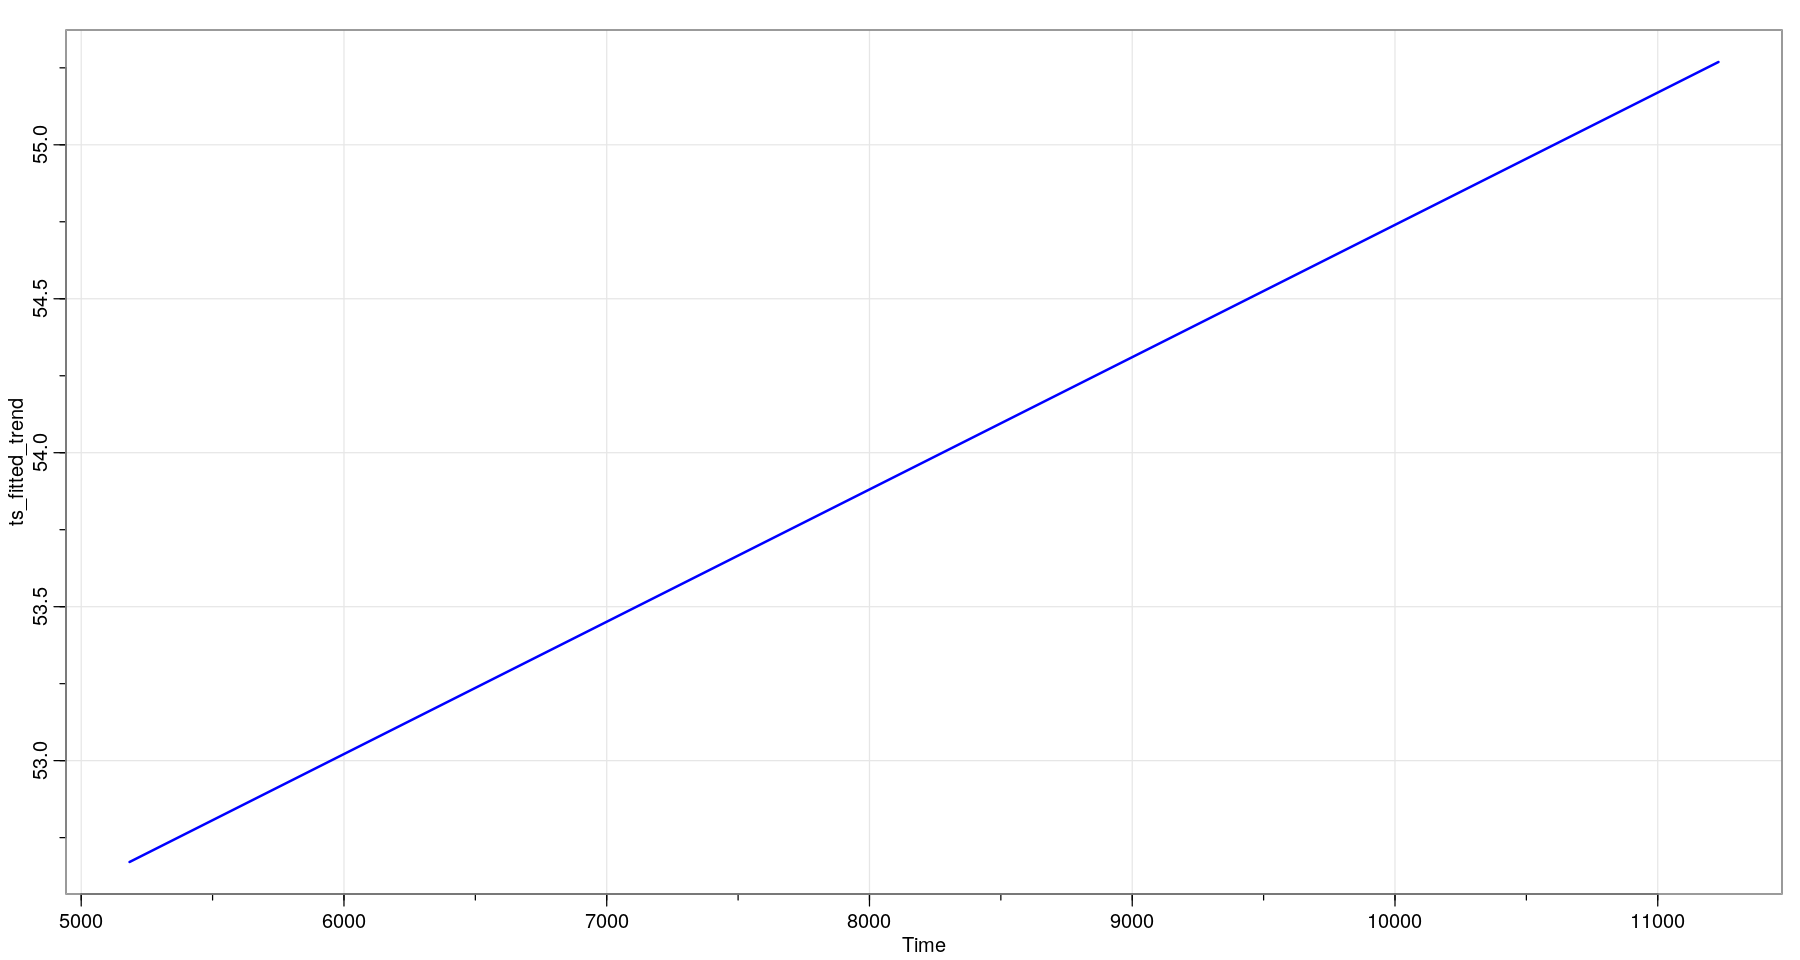

In [21]:
tsplot(ts_fitted_trend, col=4, lwd=2)

In [22]:
y1 = predict(model1,X_test)
ts_y1 = ts(y1, start=5184, freq=1)

ERROR: Error in is_tensorflow_dataset(x): objeto 'X_test' no encontrado


In [ ]:
tsplot(ts_y1, col=4, lwd=2)

In [ ]:
time(ts_fitted_trend)

In [ ]:


tsplot(ts_df, col=4, lwd=2)
lines(exp(ts_fitted_trend+y1_test)-1, col=6, lwd=2)

In [ ]:
tsplot(ts_df, col=4, lwd=2, xlim=c(5184,6048))
lines(exp(ts_fitted_trend+y1_test)-1, col=6, lwd=2)

In [ ]:
x_test = x[time(x)>=5500]
x_test = ts(x_test, start=5500, freq=1)

#sint = sin(2*pi*time(x_test))
#cost = cos(2*pi*time(x_test))

In [ ]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    #X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,] = x[i:(i+window-1)]
    
    #X_train[i,] = x_train[i:(i+window-1)]
    
    #X_test[i,,2] = sint[i:(i+window-1)]
    #X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

In [ ]:
evaluate(model1,X_test,y_test)

In [ ]:
y1_test = predict(model1,X_test)
y1_test = ts(y1_test, start=5500+3, freq=1)




#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y1, col=6, lwd=2)
lines(y1_test, col=7, lwd=2)

## Modelo 2: múltiples capas densas

Agreguemos algunas capas para darle no linealidad al modelo. Usamos como función de activación `relu`, es decir $a(x)=\max\{x,0\}$.

In [ ]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units=32, activation='relu') %>%
    layer_dense(units = 1)

In [ ]:
summary(model2)

In [ ]:
model2 %>% compile(loss = 'mse', 
                  optimizer = 'adam',
                  metrics = c('mse'))

In [ ]:
trained_model2 <- model2 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model2)

In [ ]:
evaluate(model2,X_train,y_train)

In [ ]:
y2 = predict(model2,X_train)

In [ ]:
tsplot(y_train, col=4, lwd=2)
lines(y2, col=6, lwd=2)

## Modelo 3: agregando características

Agreguemos ahora al conjunto de entrenamiento algunas funciones del tiempo. Por ejemplo, el momento del año usando $\sin$ y $\cos$ como antes

In [ ]:
window=3
pred = 1
x_train = x[time(x)<5500]
sint = sin(2*pi*time(x))
cost = cos(2*pi*time(x))

n=length(x_train)

X_train = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,,1] = x_train[i:(i+window-1)]
    X_train[i,,2] = sint[i:(i+window-1)]
    X_train[i,,3] = cost[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

In [ ]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [ ]:
summary(model3)

In [ ]:
model3 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model3 <- model3 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model3)

In [ ]:
model3$weights

In [ ]:
evaluate(model3, X_train, y_train)

In [ ]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y3, col=6, lwd=2)

## Modelo 4: características y capas

Agreguemos un par de capas densas intermedias

In [ ]:
# initialize our model
model4 <- keras_model_sequential()

model4 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 32, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [ ]:
summary(model4)

In [ ]:
model4 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model4 <- model4 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model4)

In [ ]:
evaluate(model4, X_train, y_train)

In [ ]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y4, col=6, lwd=2)

## Modelo 5: Convolutional Neural Network

La idea de la capa convolucional o CNN es similar a la de los procesos autorregresivos y a lo que veníamos haciendo antes, solo que simplifica un poco la escritura del modelo. El de abajo es esencialmente el mismo modelo 4 pero usando CNNs.


In [ ]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_conv_1d(input_shape = dim(X_train)[2:3], filters = 32, kernel_size=window, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [ ]:
summary(model5)

In [ ]:
model5 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model5 <- model5 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model5)

In [ ]:
evaluate(model5, X_train, y_train)

In [ ]:
y5 = predict(model5,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y5, col=6, lwd=2)

## Recurrent Neural Networks

Estas redes permiten "guardar estado" y en algún sentido son la generalización no lineal del Dynamic Linear model que ya vimos. Permiten en algún sentido agregar memoria.

El proceso en una capa RNN es:

## Modelo 6: Simple RNN
La red recurrente simple tiene "memoria corta" y presenta problemas de ajuste ("vanishing and exploding gradiemts") cuando uno hace el algoritmo de Backpropagation adaptado a las mismas.

In [ ]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [ ]:
summary(model6)

In [ ]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model6)

In [ ]:
evaluate(model6, X_train, y_train)

In [ ]:
y6 = predict(model6,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y6, col=6, lwd=2)

## Modelo 7: LSTM

La red recurrente LSTM funciona igual que la red RNN en principio, pero tiene más "gates" y parámetros internos para permitir guardar más estado interno. Estas redes son muy usadas para series temporales.

In [ ]:
# initialize our model
model7 <- keras_model_sequential()

model7 %>%
    layer_lstm(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [ ]:
summary(model7)

In [ ]:
model7 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model7 <- model7 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model7)

In [ ]:
evaluate(model7, X_train, y_train)

In [ ]:
y7 = predict(model7,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y7, col=6, lwd=2)

## Modelo 8: LSTM +  capas

Agreguemos alguna capa densa más.

In [ ]:
# initialize our model
model8 <- keras_model_sequential()

model8 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 8, activation="relu") %>%
    layer_dense(units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [ ]:
summary(model8)

In [ ]:
model8 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [ ]:
trained_model8 <- model8 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


In [ ]:
plot(trained_model8)

In [ ]:
evaluate(model8, X_train, y_train)

In [ ]:
y8 = predict(model8,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y8, col=6, lwd=2)

## Evaluación.

Evaluemos algunos de estos modelos haciendo la predicción sobre los años que faltan.

In [ ]:
x_test = x[time(x)>=5500]
x_test = ts(x_test, start=5500, freq=1)

sint = sin(2*pi*time(x_test))
cost = cos(2*pi*time(x_test))

In [ ]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,,2] = sint[i:(i+window-1)]
    X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

In [ ]:
evaluate(model8,X_test,y_test)

In [ ]:
y8_test = predict(model8,X_test)
y8_test = ts(y8_test, start=5500+3, freq=1)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y8, col=6, lwd=2)
lines(y8_test, col=7, lwd=2)

In [ ]:
y8_test = predict(model8,X_test)
y8_test = ts(y8_test, start=5500+3, freq=1)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x[5184:6000], col=4, lwd=2)
lines(y8[5184:6000], col=6, lwd=2)
lines(y8_test, col=7, lwd=2)

In [ ]:
ts_test_trn = ts(fitted(fit), start=1, freq=1)
#tsplot(ts_test_trn, col=4, lwd=2)
length(ts_test_trn)

In [ ]:
length(y8)
length(y8_test)

In [ ]:
#time(x)

In [ ]:

tsplot((x+ts_test_trn), col=4, lwd=2, xlim=c(5306,6075))
lines((y8+ts_test_trn[1:5497]), col=6, lwd=2)
#lines((y8_test+ts_test_trn[5500:6044]), col=2, lwd=2)
#tsplot((y8_test), col=4, lwd=2, xlim=c(5500,6075))

In [ ]:
#y8_test+ts_test_trn[5500:6044]

In [ ]:
#length(y8_test)

In [ ]:
#length(ts_test_trn[5500:6044])

In [ ]:
length(y8)

In [ ]:
length(ts_test_trn)